Trial 15 Complete [00h 00m 46s]
val_loss: 0.544779360294342

Best val_loss So Far: 0.5309776067733765
Total elapsed time: 00h 18m 36s

--- Hyperparameter Search Complete ---
Results summary
Results in kerastuner_dir/combined_water_level
Showing 3 best trials
Objective(name="val_loss", direction="min")

Trial 13 summary
Hyperparameters:
units: 160
dropout_rate: 0.1
learning_rate: 0.001
Score: 0.5309776067733765

Trial 03 summary
Hyperparameters:
units: 256
dropout_rate: 0.15000000000000002
learning_rate: 0.001
Score: 0.5383506417274475

Trial 10 summary
Hyperparameters:
units: 96
dropout_rate: 0.25
learning_rate: 0.01
Score: 0.5389879941940308

The best hyperparameters found are:
- Units: 160
- Dropout Rate: 0.100
- Learning Rate: 0.001



/home/yasirgunes/bitirme/venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Best model saved as 'best_tuned_combined_model.keras'
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

--- FINAL TUNED Model Performance on Validation Set ---
Day 1 Ahead -> MAE: 0.1326 m, RMSE: 0.2424 m, R²: 0.8982
Day 2 Ahead -> MAE: 0.2431 m, RMSE: 0.4457 m, R²: 0.6553
Day 3 Ahead -> MAE: 0.3086 m, RMSE: 0.5467 m, R²: 0.4807
Day 4 Ahead -> MAE: 0.3417 m, RMSE: 0.5930 m, R²: 0.3884
Day 5 Ahead -> MAE: 0.3606 m, RMSE: 0.6165 m, R²: 0.3385
Day 6 Ahead -> MAE: 0.3742 m, RMSE: 0.6312 m, R²: 0.3060
Day 7 Ahead -> MAE: 0.3839 m, RMSE: 0.6426 m, R²: 0.2798


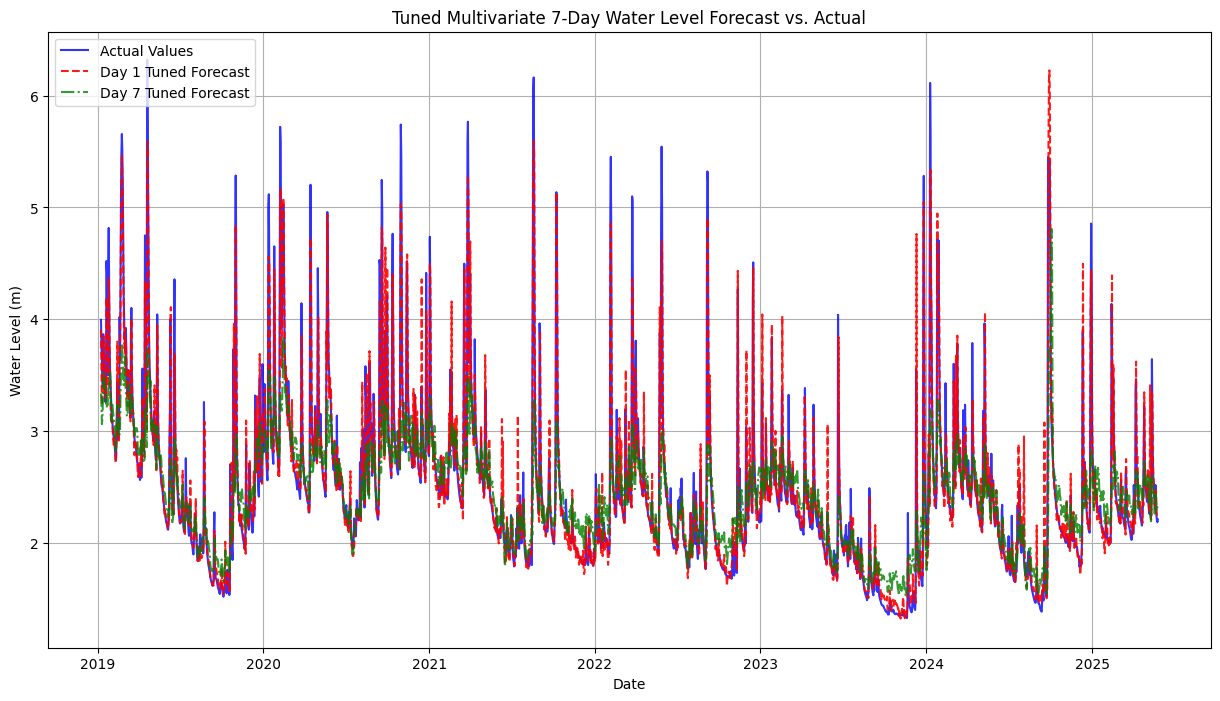

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt # Import KerasTuner
import joblib

# -------------------------------------------------------------------
# 1. Load and Prepare Data (Same as your original script)
# -------------------------------------------------------------------
df_multi = pd.read_csv('combined_dataset.csv', index_col='datetime', parse_dates=True)
df_multi = df_multi[['stage_m'] + [col for col in df_multi.columns if col != 'stage_m']]

print("Columns in order:", df_multi.columns.tolist())

split_date_train_end = '2018-04-21'
split_date_val_start = '2019-01-01'
train_data = df_multi.loc[df_multi.index < split_date_train_end]
val_data = df_multi.loc[df_multi.index >= split_date_val_start]

scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(train_data)
scaled_val_data = scaler.transform(val_data)

# Save the scaler, as we will need it for evaluation
joblib.dump(scaler, 'multivariate_combined_scaler.joblib')

N_PAST = 7
N_FUTURE = 7

def create_sequences(data, n_past, n_future):
    X, y = [], []
    target_col_index = 0
    for i in range(n_past, len(data) - n_future + 1):
        X.append(data[i - n_past:i, :])
        y.append(data[i:i + n_future, target_col_index])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(scaled_train_data, N_PAST, N_FUTURE)
X_val, y_val = create_sequences(scaled_val_data, N_PAST, N_FUTURE)

print(f"\nX_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
n_features = X_train.shape[2]

# -------------------------------------------------------------------
# 2. Define the Model-Building Function for the Tuner
# -------------------------------------------------------------------
def build_model(hp):
    """
    Builds a compiled LSTM Encoder-Decoder model.
    `hp` is a KerasTuner HyperParameters object.
    """
    # --- Define the Hyperparameter Search Space ---
    # We will tune the number of units, the dropout rate, and the learning rate.
    units = hp.Int('units', min_value=64, max_value=256, step=32)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.4, step=0.05)
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # --- Define the Model Architecture (same as before) ---
    inputs = Input(shape=(N_PAST, n_features))
    
    # Encoder
    encoder_l1 = LSTM(units, return_sequences=True, dropout=dropout_rate)(inputs)
    encoder_l2, state_h, state_c = LSTM(units, return_sequences=False, dropout=dropout_rate, return_state=True)(encoder_l1)
    encoder_states = [state_h, state_c]
    
    # Decoder
    decoder_inputs = RepeatVector(N_FUTURE)(encoder_l2)
    decoder_l1 = LSTM(units, return_sequences=True, dropout=dropout_rate)(decoder_inputs, initial_state=encoder_states)
    decoder_l2 = LSTM(units, return_sequences=True, dropout=dropout_rate)(decoder_l1)
    output = TimeDistributed(Dense(1))(decoder_l2)
    
    model = Model(inputs=inputs, outputs=output)

    # --- Compile the Model ---
    # The optimizer is created with the hyperparameter 'learning_rate'
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# -------------------------------------------------------------------
# 3. Instantiate the Tuner and Run the Search
# -------------------------------------------------------------------
# We use RandomSearch. It will randomly try different combinations of hyperparameters.
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',         # The metric to minimize
    max_trials=15,                # Total number of hyperparameter combinations to test
    executions_per_trial=1,       # Number of models to train for each trial. Set to 1 for speed.
    directory='kerastuner_dir',   # Directory to store the results
    project_name='combined_water_level'
)

# A callback to stop training early if the validation loss doesn't improve
stop_early = EarlyStopping(monitor='val_loss', patience=10)

print("\n--- Starting Hyperparameter Search ---")
tuner.search(
    X_train, y_train,
    epochs=100, # Max epochs for each trial; EarlyStopping will likely stop it sooner
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[stop_early],
    verbose=1
)

# -------------------------------------------------------------------
# 4. Retrieve the Best Model and Hyperparameters
# -------------------------------------------------------------------
print("\n--- Hyperparameter Search Complete ---")

# Show the top 3 best hyperparameter combinations
tuner.results_summary(num_trials=3)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The best hyperparameters found are:
- Units: {best_hps.get('units')}
- Dropout Rate: {best_hps.get('dropout_rate'):.3f}
- Learning Rate: {best_hps.get('learning_rate')}
""")

# Get the best model directly from the tuner
# The tuner automatically re-trains the best model on the full training data
best_model = tuner.get_best_models(num_models=1)[0]
best_model.save('best_tuned_combined_model.keras')
print("\nBest model saved as 'best_tuned_combined_model.keras'")

# -------------------------------------------------------------------
# 5. Evaluate the Final Tuned Model
# -------------------------------------------------------------------
# Load the scaler (as if we were in a separate evaluation script)
loaded_scaler = joblib.load('multivariate_combined_scaler.joblib')
predictions_scaled = best_model.predict(X_val).squeeze()

# --- Special handling for inverse scaling (same as your original script) ---
dummy_preds = np.zeros((len(predictions_scaled.flatten()), n_features))
dummy_preds[:, 0] = predictions_scaled.flatten()
rescaled_preds = loaded_scaler.inverse_transform(dummy_preds)
predictions_original = rescaled_preds[:, 0].reshape(y_val.shape)

dummy_true = np.zeros((len(y_val.flatten()), n_features))
dummy_true[:, 0] = y_val.flatten()
rescaled_true = loaded_scaler.inverse_transform(dummy_true)
y_true_original = rescaled_true[:, 0].reshape(y_val.shape)

print("\n--- FINAL TUNED Model Performance on Validation Set ---")
for i in range(N_FUTURE):
    day = i + 1
    mae = mean_absolute_error(y_true_original[:, i], predictions_original[:, i])
    rmse = np.sqrt(mean_squared_error(y_true_original[:, i], predictions_original[:, i]))
    r2 = r2_score(y_true_original[:, i], predictions_original[:, i])
    print(f"Day {day} Ahead -> MAE: {mae:.4f} m, RMSE: {rmse:.4f} m, R²: {r2:.4f}")

# --- Visualize the results ---
val_dates = val_data.index[N_PAST:len(y_true_original) + N_PAST]
plt.figure(figsize=(15, 8))
plt.plot(val_dates, y_true_original[:, 0], label='Actual Values', color='blue', alpha=0.8)
plt.plot(val_dates, predictions_original[:, 0], label='Day 1 Tuned Forecast', color='red', linestyle='--', alpha=0.9)
plt.plot(val_dates, predictions_original[:, 6], label='Day 7 Tuned Forecast', color='green', linestyle='-.', alpha=0.8)
plt.title('Tuned Multivariate 7-Day Water Level Forecast vs. Actual')
plt.xlabel('Date')
plt.ylabel('Water Level (m)')
plt.legend()
plt.grid(True)
plt.show()


--- Starting Advanced Error Analysis ---

Error Analysis DataFrame Head:
            actual_level  predicted_level     error
date                                               
2019-01-08         3.993         3.904474 -0.088526
2019-01-09         3.767         3.551731 -0.215269
2019-01-10         3.606         3.229246 -0.376754
2019-01-11         3.478         3.291190 -0.186810
2019-01-12         3.392         3.338620 -0.053380


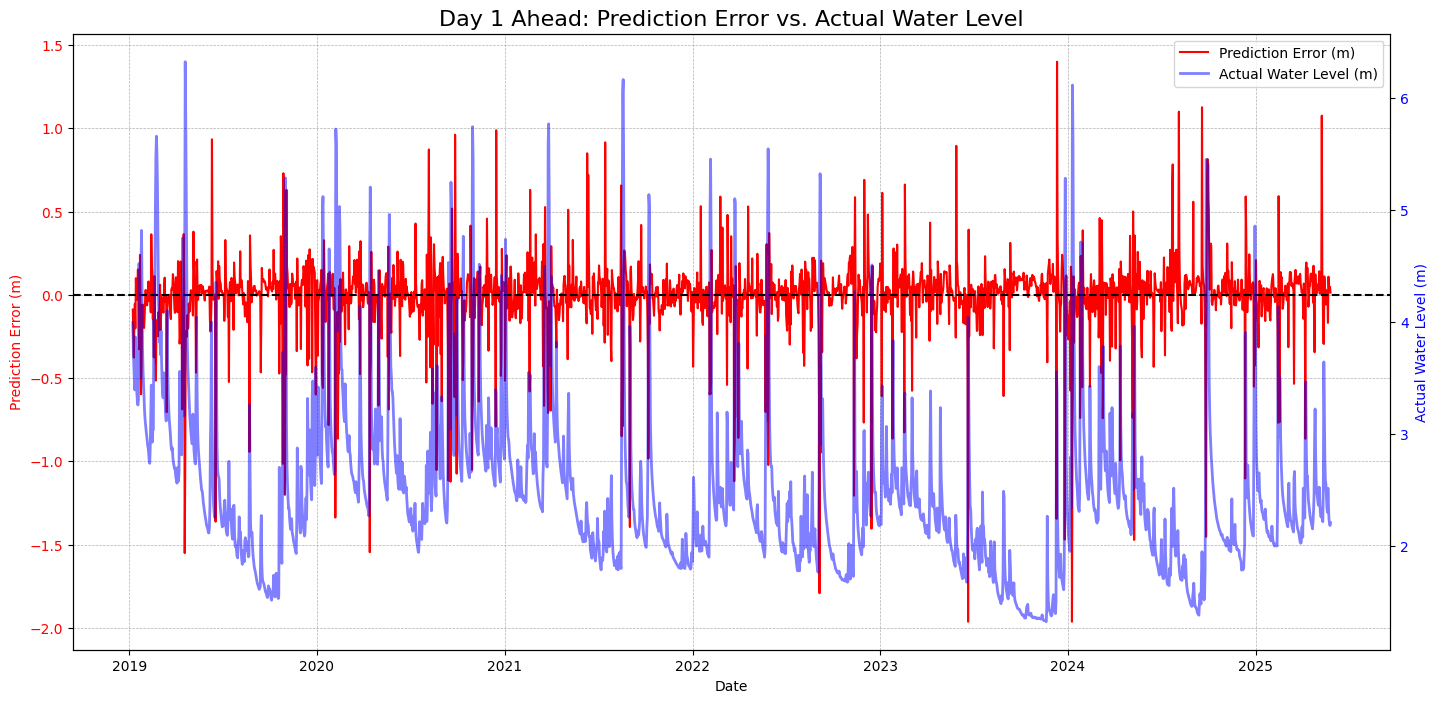

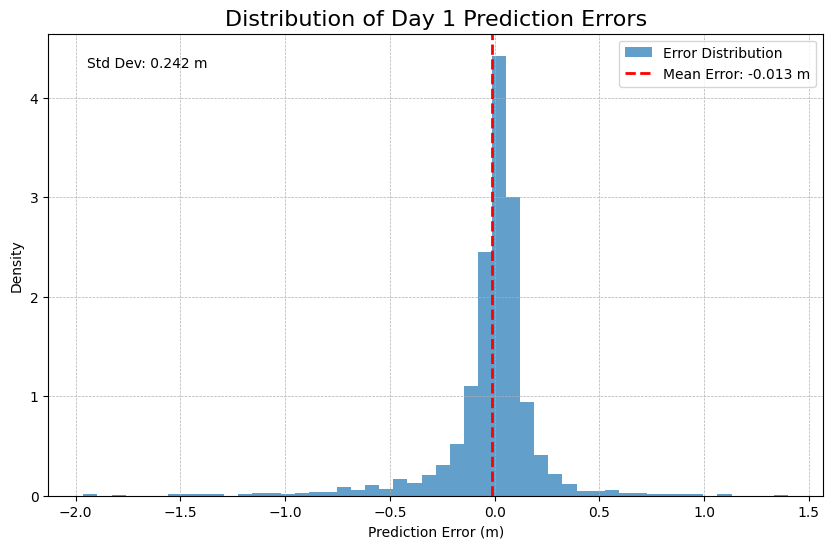

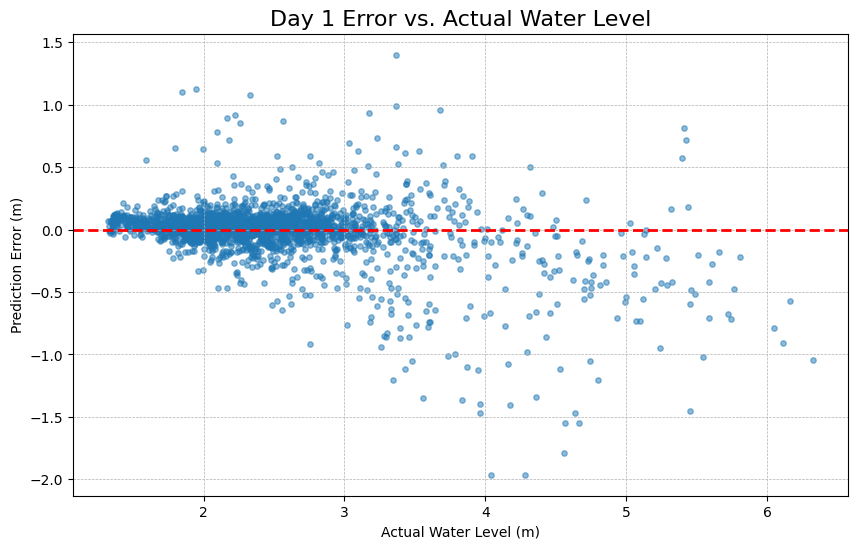

In [2]:
# ===================================================================
# 6. ADVANCED ERROR ANALYSIS
# This section assumes you have already run the previous steps and have
# the following variables in your environment:
# - y_true_original: The actual water levels from the validation set
# - predictions_original: The model's predicted water levels
# - val_dates: The corresponding dates for the validation set
# ===================================================================

print("\n--- Starting Advanced Error Analysis ---")

# --- Step 1: Calculate Error and Create a DataFrame ---
# We will focus on the 1-day ahead forecast as it's the most accurate
day_to_analyze = 0 # 0 for Day 1, 1 for Day 2, etc.

# Calculate the error (Predicted - Actual)
errors = predictions_original[:, day_to_analyze] - y_true_original[:, day_to_analyze]

# Create a new DataFrame for easy analysis and plotting
error_df = pd.DataFrame({
    'date': val_dates,
    'actual_level': y_true_original[:, day_to_analyze],
    'predicted_level': predictions_original[:, day_to_analyze],
    'error': errors
}).set_index('date')

print("\nError Analysis DataFrame Head:")
print(error_df.head())

# --- Step 2: Create the Visualizations ---

# --- PLOT 1: Prediction Error Over Time vs. Actual Water Level ---
fig, ax1 = plt.subplots(figsize=(17, 8))

# Plot the error on the primary y-axis
ax1.plot(error_df.index, error_df['error'], color='red', lw=1.5, label='Prediction Error (m)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Prediction Error (m)', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.axhline(y=0, color='black', lw=1.5, linestyle='--') # Add a zero-error line

# Create a secondary y-axis to plot the actual water level
ax2 = ax1.twinx()
ax2.plot(error_df.index, error_df['actual_level'], color='blue', lw=2, alpha=0.5, label='Actual Water Level (m)')
ax2.set_ylabel('Actual Water Level (m)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Add title and legend
plt.title(f'Day {day_to_analyze+1} Ahead: Prediction Error vs. Actual Water Level', fontsize=16)
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()


# --- PLOT 2: Distribution of Prediction Errors (Histogram) ---
mean_error = error_df['error'].mean()
std_error = error_df['error'].std()

plt.figure(figsize=(10, 6))
plt.hist(error_df['error'], bins=50, density=True, alpha=0.7, label='Error Distribution')
plt.axvline(mean_error, color='red', linestyle='--', lw=2, label=f'Mean Error: {mean_error:.3f} m')
plt.title(f'Distribution of Day {day_to_analyze+1} Prediction Errors', fontsize=16)
plt.xlabel('Prediction Error (m)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.text(0.05, 0.95, f'Std Dev: {std_error:.3f} m', transform=plt.gca().transAxes, verticalalignment='top')
plt.show()


# --- PLOT 3: Prediction Error vs. Actual Water Level (Scatter Plot) ---
plt.figure(figsize=(10, 6))
plt.scatter(error_df['actual_level'], error_df['error'], alpha=0.5, s=15)
plt.axhline(y=0, color='red', linestyle='--', lw=2)
plt.title(f'Day {day_to_analyze+1} Error vs. Actual Water Level', fontsize=16)
plt.xlabel('Actual Water Level (m)')
plt.ylabel('Prediction Error (m)')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()